In [1]:
from rasterstats import zonal_stats
from tobler.util import h3fy
import geopandas as gpd
import pandas as pd

In [2]:
CITY_BOUNDARY = gpd.read_file("./data/Enschede_boundaries.geojson")

In [3]:
def create_hexagons(city:gpd, resolution:int,):
    print("Creating hexagons...")
    hexes = h3fy(city, resolution=10, clip=True)
        
    hex_wgs84 = hexes.to_crs(epsg=4326)
    
    print("Hexagons created:", hex_wgs84.size)
    return hex_wgs84

In [4]:
hexes = create_hexagons(CITY_BOUNDARY, 10)

Creating hexagons...
Hexagons created: 11031


In [12]:
def calculate_stats(raster_path:str, zones:gpd):
    print("Calculating stats...")
    if "hex_id" not in zones.columns:
        zones["hex_id"] = range(len(zones))
    stats = zonal_stats(
        zones,
        raster_path,
        stats=["max"],
        geojson_out=False
    )
    
    stats_df = pd.DataFrame(stats)
    hexes_lst = zones.join(stats_df)
    print("Stats calculated:", hexes_lst.head())
    return hexes_lst

In [ ]:
hex_lst = calculate_stats("./data/LST_Enschede.tif", hexes)

In [ ]:
hex_lst.plot(column="max")

In [21]:
import rasterio
from rasterio.mask import mask
import numpy as np


def calculate_stats(raster_path:str, zones:gpd, stat:str):
    raster = rasterio.open(raster_path)
    def derive_stats(geom, data, **mask_kw):
        masked, mask_transform = mask(dataset=data, shapes=(geom,),
                                    crop=True, all_touched=True, filled=True)
        return masked
    
    zones[stat] = zones.geometry.apply(derive_stats, data=raster).apply(np.mean)
    
    return zones

<Axes: >

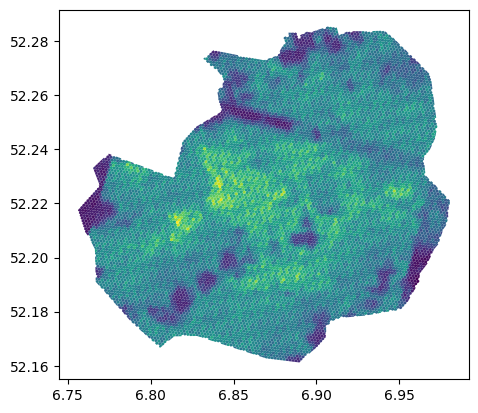

In [22]:
zones= calculate_stats("./data/LST_Enschede.tif", hexes, "mean")
zones.plot(column="mean")

In [23]:
lst = rasterio.open("./data/LST_Enschede.tif")
lst.plot()

AttributeError: 'DatasetReader' object has no attribute 'plot'